<a href="https://colab.research.google.com/github/prosvirinKir/rzd/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install pyreadr

     |████████████████████████████████| 419kB 4.3MB/s 


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime
sns.set(style="whitegrid", font_scale=1.4)
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
from tqdm import trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
import pyreadr
from tqdm.notebook import tqdm, trange

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
df = pyreadr.read_r("/content/gdrive/MyDrive/DLS/hw_segmentation/GOR.rds")

In [ ]:
df = df[None]
df = df.loc[:, (df != df.iloc[0]).any()] 
df = df.drop(df[df.TARGET_2 < 0].index)
pd.set_option("display.max_columns", 200)
df = df.drop(["KODOTS", "RASHIFROVKA", "PROVERENO", "PLUS", "STATUS", "CATEGORY", "KODNAPR", "UPDATTR", "TARGET_1", "TARGET_3"], axis=1)
df["AVG_BALL"] = df["AVG_BALL"].str.replace(',', '.')
df["AVG_KILO"] = df["AVG_KILO"].str.replace(',', '.')
df = df.drop(["LINE"], axis=1)

In [ ]:
df.reset_index(inplace=True)
df = df.drop(['index'], axis=1)

In [ ]:
labels = df['TARGET_2']
labels = np.hstack((0, ))

In [ ]:
KM_unique = sorted(df.KM.unique())

In [ ]:
df = df.sort_values(["KM", "YEAR", "MONTH", "DAY"])
df

,PCH,YEAR,MONTH,DAY,KM,M,BALL,SPEED_RES_PAS,SPEED_RES_FRE,SPEED_RES_EMPTY,SPEED_NORM_PAS,SPEED_NORM_FRE,LENGTH_KILO,RIX2,RIX3,RIX4,USH2,USH3,USH4,SUG2,SUG3,SUG4,PLU2,PLU3,PLU4,PER2,PER3,PER4,PRO2,PRO3,PRO4,OTS2,OTS3,OTS4,UKL,DRU,AVG_BALL,AVG_KILO,X2049_3,X2049_4,X2065_1,X2065_2,X2065_3,X2065_4,X2067_2,X2067_3,X2067_4,X2081_1,X2081_2,X2081_3,X2081_4,X2097_2,X2097_3,X2097_4,X2113_2,X2113_3,X2113_4,X2129_1,X2129_2,X2129_3,X2129_4,X2145_1,X2145_2,X2145_3,X2145_4,X2161_1,X2161_2,X2161_3,X2161_4,X2177_4,X2179_3,X2179_4,X2193_4,X2195_3,X2195_4,X2209_4,X2211_3,X2211_4,X2213_4,X2215_4,X2218_4,X2221_3,X2221_4,X2222_3,X2222_4,X2223_3,X2223_4,X2226_3,X2226_4,X2227_3,X2227_4,X2228_3,X2228_4,X2229_3,X2229_4,X2230_4,X2231_4,X2232_4,X2233_4,X2243_4,X2244_4,X2246_4,X2289_3,X2289_4,X2290_3,X2290_4,X2291_3,X2291_4,X3199_3,X3312_3,X3313_3,MISTAKES_GROUP,SPEED_RES_PAS_O,SPEED_RES_FRE_O,SPEED_NORM_PAS_O,SPEED_NORM_FRE_O,KR,DZ,T.,Z,IS,UR.PR,PRZH,X.,STRELKA,OBK,MOST,NR,ISM,PR_PREDUPR,EXCLUDE,TARGET_2,DIF_PAS_SP,DIF_FRE_SP,REPAIR_1,REPAIR_2,O_1,O_2,O_3,O_4,O_T,delta_OTS_2,delta_OTS_3,delta_OTS_4,delta_O_1,delta_O_2,delta_O_3,delta_O_4,delta_O_T
1102,13,2017,1,19,-1,994,10,1000,1000,1000,70,70,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000,1000,1000,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,0,0,0,0,-999,-999,-999,-999,-999,-999,-999,-999
4380,13,2017,2,19,-1,995,10,1000,1000,1000,70,70,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000,1000,1000,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7071,13,2017,3,20,-1,994,10,1000,1000,1000,70,70,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000,1000,1000,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43893,13,2018,6,5,-1,995,10,1000,1000,1000,70,70,1000,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,10,1000,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000,1000,70,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0,2,0,0,2,-999,-999,-999,-999,-999,-999,-999,-999
53253,13,2018,10,26,-1,996,10,1000,1000,1000,70,70,1040,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,10,1040,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000,1000,70,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94352,27,2020,1,19,1569,1,10,1000,1000,1000,100,80,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000,1000,100,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
94462,27,2020,1,29,1569,1,10,1000,1000,1000,100,80,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
HISTORY_SIZE = 5
train = torch.zeros((1, HISTORY_SIZE, df.shape[1]))
label = torch.zeros((1))

In [ ]:
for km in tqdm(KM_unique):
    
    df_km = df[df['KM'] == km]
    y_km = df_km['TARGET_2'].values # не сдвинутые 
    df_km['TARGET_2'] = np.hstack((0, y_km[:-1]))
    
    cur_km = 0
    max_iter = df_km.shape[0]
    
    while max_iter >= cur_km + HISTORY_SIZE:
        train_km = torch.FloatTensor(df_km.iloc[cur_km:cur_km + HISTORY_SIZE].to_numpy(dtype=np.float16))
        train = torch.vstack((
            train,
            torch.unsqueeze(train_km, 0)))
        label = torch.vstack((label, torch.tensor(y_km[cur_km + HISTORY_SIZE - 1])))

        cur_km += HISTORY_SIZE


  0%|          | 0/1571 [00:00<?, ?it/s]

In [8]:
torch.save(train, 'train_5.pt')
torch.save(label, 'label_5.pt')

In [147]:
X = torch.load('/content/gdrive/MyDrive/DLS/hw_segmentation/train_5.pt')

In [148]:
y = torch.load('/content/gdrive/MyDrive/DLS/hw_segmentation/label_5.pt')

In [86]:
y = y.long()

In [87]:
y.dtype

torch.int64

In [149]:
data = torch.utils.data.DataLoader(list(zip(X, y)), batch_size=20871, shuffle=True)

In [150]:
for X_batch, y_batch in data:
  X_shuffle = X_batch
  y_shuffle = y_batch
  break

In [151]:
(X == X_shuffle).all()

tensor(False)

In [152]:
X_train = torch.utils.data.DataLoader(X[:15000], batch_size=32) #to shuffle
X_test = torch.utils.data.DataLoader(X[15000:], batch_size=32)

y_train = torch.utils.data.DataLoader(y[:15000], batch_size=32)
y_test = torch.utils.data.DataLoader(y[15000:], batch_size=32)

In [153]:
train_dl = torch.utils.data.DataLoader(list(zip(X_shuffle[:15000], y_shuffle[:15000])), batch_size=128)
test_dl = torch.utils.data.DataLoader(list(zip(X_shuffle[15000:], y_shuffle[15000:])), batch_size=128)

In [154]:
for x, y in train_dl:
  print(x.shape, y.shape)
  break

torch.Size([128, 5, 149]) torch.Size([128, 1])


In [155]:
def training(model, criterion, optimizer, num_epochs, train_dl, test_dl, max_grad_norm=2):
    for e in trange(num_epochs, leave=False):
        model.train()
        num_iter = 0
        pbar = tqdm(train_dl, leave=False)
        for X_batch, y_batch in pbar:
            optimizer.zero_grad()
            input_embeds = X_batch.to(device)
            # print('input_embeds.shape =', input_embeds.shape)
            # print('input_embeds[0].shape =', input_embeds[0].shape)
            # print('input_embeds[0] =', input_embeds[0])
            labels = y_batch.to(device).flatten()
            # print(labels.flatten())
            # print('labels.shape =', labels.shape)
            # print('labels[0] =', labels[0])
            prediction = model(input_embeds)
            loss = criterion(prediction[:,0], labels)
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1
        valid_loss = 0
        valid_acc = 0
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for X_batch, y_batch in test_dl:
                input_embeds = X_batch.to(device)
                labels = y_batch.to(device).flatten()
                prediction = model(input_embeds)
                valid_loss += criterion(prediction[:,0], labels)
                correct += (labels == prediction.argmax(-1)).float().sum()
                num_objs += len(labels)
                num_iter += 1

        print(f"Valid Loss: {valid_loss / num_iter}, accuracy: {correct/num_objs}")

In [156]:
class GRU(nn.Module):
    def __init__(self, embed_size, hidden_size):
        super().__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size

        self.w_rh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_rh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_rx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_rx = nn.Parameter(torch.rand(1, hidden_size))

        self.w_zh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_zh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_zx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_zx = nn.Parameter(torch.rand(1, hidden_size))

        self.w_nh = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_nh = nn.Parameter(torch.rand((1, hidden_size)))
        self.w_nx = nn.Parameter(torch.rand(embed_size, hidden_size))
        self.b_nx = nn.Parameter(torch.rand(1, hidden_size))

    def forward(self, x, hidden = None):
        '''
        x – torch.FloatTensor with the shape (bs, seq_length, emb_size)
        hidden - torch.FloatTensro with the shape (bs, hidden_size)
        return: torch.FloatTensor with the shape (bs, hidden_size)
        '''
        if hidden is None:
            hidden = torch.zeros((x.size(0), self.hidden_size)).to(x.device)
        
        for cur_idx in range(x.size(1)):
            r = torch.sigmoid(
                x[:, cur_idx] @ self.w_rx + self.b_rx + hidden @ self.w_rh + self.b_rh
            )
            z = torch.sigmoid(
                x[:, cur_idx] @ self.w_zx + self.b_zx + hidden @ self.w_zh + self.b_zh
            )
            n = torch.tanh(
                x[:, cur_idx] @ self.w_nx + self.b_nx + r * (hidden @ self.w_nh + self.b_nh)
            )
            hidden = (1 - z) * n + z * hidden

        return hidden

In [157]:
class GRUModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=2):
        super().__init__()
        self.gru = GRU(embed_size, hidden_size)
        self.cls = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        hidden = self.gru(x)
        output = self.cls(hidden)
        return output

In [158]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [159]:
num_features = 149
n_hidden = 128
model = GRUModel(num_features, n_hidden).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

num_epochs = 20
max_grad_norm = 1.0

In [160]:
training(model, criterion, optimizer, num_epochs, train_dl, test_dl, max_grad_norm)

RuntimeError: ignored

In [ ]:
test_dl = torch.utils.data.DataLoader(list(zip(X_shuffle[15000:], y_shuffle[15000:])), batch_size=5000)

In [123]:
for X_batch, y_batch in test_dl:
  preds = model(X_batch.to(device))
  break

In [124]:
preds = preds.detach().cpu().numpy()

In [125]:
preds.shape

(5000, 2)

In [128]:
test_auc = roc_auc_score(y_batch, preds[:,1])
test_auc

0.5022524677031395

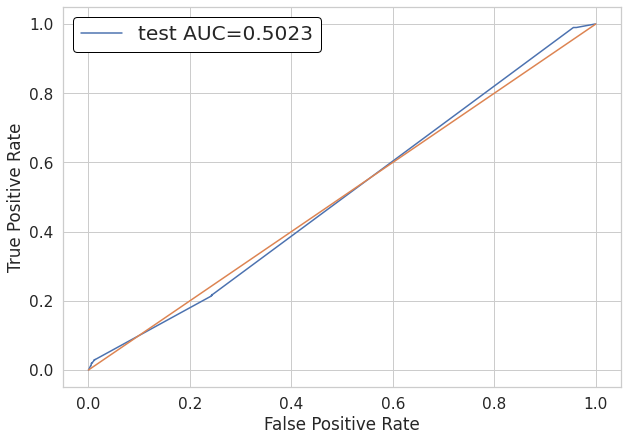

In [129]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_batch, preds[:,1])[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
# plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()